# 7.3 基于单层决策树构建弱分类器

In [1]:
import numpy as np
def loadSimpData():
    datMat = np.mat([[ 1. ,  2.1],
        [ 2. ,  1.1],
        [ 1.3,  1. ],
        [ 1. ,  1. ],
        [ 2. ,  1. ]])
    classLabels = [1.0, 1.0, -1.0, -1.0, 1.0]
    return datMat,classLabels

In [2]:
datMat,classLabels=loadSimpData()

In [3]:
def stumpClassify(dataMat,dimen,threshVal,threshIneq):
    retArray=np.ones((dataMat.shape[0],1))
    if threshIneq=='lt':
        retArray[dataMat[:,dimen]<=threshVal]=-1.0
    else:
        retArray[dataMat[:,dimen]>threshVal]=-1.0
    return retArray


def buildStump(dataArr,classLabels,D):
    dataMat=np.mat(dataArr)
    labelMat=np.mat(classLabels).transpose()
    n,m=dataMat.shape
    numSteps=10.0
    bestStump={}
    bestClassEst=np.mat(np.zeros((n,1)))
    minErr=np.inf
    for i in range(m):
        rangeMin=dataMat[:,i].min()
        rangeMax=dataMat[:,i].max()
        stepsize=(rangeMax-rangeMin)/numSteps
        for j in range(-1,int(numSteps)+1):
            for inequal in ['lt','gt']:
                threshVal=(rangeMin+1.0*j*stepsize)
                predictedVals=stumpClassify(dataMat,i,threshVal,inequal)
                errArr=np.mat(np.ones((n,1)))
                errArr[predictedVals==labelMat]=0
                weightedError=D.T*errArr
                if(weightedError<minErr):
                    minErr=weightedError
                    bestClassEst=predictedVals.copy()
                    bestStump['dim']=i
                    bestStump['thresh']=threshVal
                    bestStump['ineq']=inequal
    return bestStump,minErr,bestClassEst


In [4]:
D=np.ones((5,1))/5
bestStump,minErr,bestClassEst=buildStump(datMat,classLabels,D)

# 7.4 完整AdaBoost算法的实现

In [5]:
import math
def adaBoostTrainDS(dataArr,classLabels,numIt=40):
    labelsMat=np.mat(classLabels).T
    weakClassArr=[]
    n=dataArr.shape[0]
    D=np.mat(np.ones((n,1))/n)
    aggClassEst=np.mat(np.zeros((n,1)))
    for i in range(numIt):
        bestStump,error,classEst=buildStump(dataArr,classLabels,D)
        alpha=0.5*math.log((1.0-error)/max(error,1e-16))
        bestStump['alpha']=alpha
        weakClassArr.append(bestStump)
        expon=np.multiply(-1*alpha*labelsMat,classEst)
        D=np.multiply(D,np.exp(expon))
        D=D/D.sum()
        aggClassEst+=alpha*classEst
        aggErrors=np.zeros([n,1])
        aggErrors[np.sign(aggClassEst)!=labelsMat]=1
        errorRate=aggErrors.sum()/n
        if errorRate==0.0:
            break
    return weakClassArr,aggClassEst

In [6]:
classifierArr,aggClassEst=adaBoostTrainDS(datMat,classLabels,50)

## 7.5 测试算法：基于AdaBoost的分类

In [7]:
def adaClassify(dataToclass,classifierArr):
    dataMat=np.mat(dataToclass)
    n=dataMat.shape[0]
    aggClassEst=np.mat(np.zeros((n,1)))
    for i in range(len(classifierArr)):
        classEst=stumpClassify(dataMat,classifierArr[i]['dim'],classifierArr[i]['thresh'],classifierArr[i]['ineq'])
        aggClassEst+=classEst
    return np.sign(aggClassEst)

In [8]:
adaClassify([[5,5],[0,0]],classifierArr)

matrix([[ 1.],
        [-1.]])

## 7.5 示例：在一个难数据集上应用AdaBoost

In [9]:
def loadDataSet(fileName):
    with open(fileName) as frTrain:
        trainingSet = []
        trainingLabels = []
        for line in frTrain.readlines():
            currLine = line.strip().split('\t')
            lineArr =[]
            for i in range(len(currLine)-1):
                lineArr.append(float(currLine[i]))
            trainingSet.append(lineArr)
            trainingLabels.append(float(currLine[-1]))
    return trainingSet,trainingLabels

In [10]:
trainData,trianlabel=loadDataSet('horseColicTraining2.txt')
testData,testlabel=loadDataSet('horseColicTest2.txt')

In [11]:
classifierArr,aggClassEst=adaBoostTrainDS(np.mat(trainData),trianlabel,50)
predictLabels=adaClassify(testData,classifierArr)

In [12]:
res=np.zeros((len(predictLabels),1))
res[predictLabels!=np.mat(testlabel).T]=1
res.sum()/len(predictLabels)

0.31343283582089554

## 7.7 非均衡问题

In [19]:
def plotROC(predStrengths, classLabels):
    import matplotlib.pyplot as plt
    cur=(1.0,1.0)
    ySum=0.0
    numPosClas=sum(np.array(classLabels)==1.0)
    yStep=1/float(numPosClas)
    xStep=1/float(len(classLabels)-numPosClas)
    sortedIndicies=predStrengths.argsort()
    fig=plt.figure()
    fig.clf()
    ax=plt.subplot(111)
    for index in list(sortedIndicies.A1):
        if classLabels[index] == 1.0:
            delX=0
            delY=yStep;
        else:
            delX=xStep
            delY=0;
            ySum+=cur[1]
        ax.plot([cur[0],cur[0]-delX],[cur[1],cur[1]-delY], c='b')
        cur=(cur[0]-delX,cur[1]-delY)
    ax.plot([0,1],[0,1],'b--')
    plt.xlabel('False positive rate'); plt.ylabel('True positive rate')
    plt.title('ROC curve for AdaBoost horse colic detection system')
    ax.axis([0,1,0,1])
    plt.show()
    print "the Area Under the Curve is: ",ySum*xStep

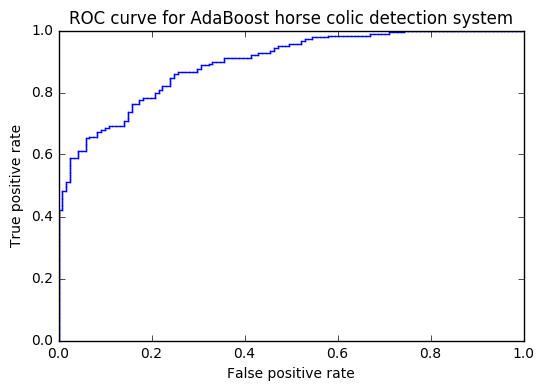

the Area Under the Curve is:  0.895394187018


In [20]:
plotROC(aggClassEst.T,trianlabel)